In [373]:
# Imports
import numpy as np
import autograd.numpy as anp
import time
import tensorly

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm, inv
from scipy.optimize import minimize

import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
from pymanopt.manifolds import Product, Euclidean, Stiefel, SymmetricPositiveDefinite
from pymanopt import Problem
from pymanopt.optimizers import SteepestDescent

np.set_printoptions(suppress=True, precision=4)

# Transformations

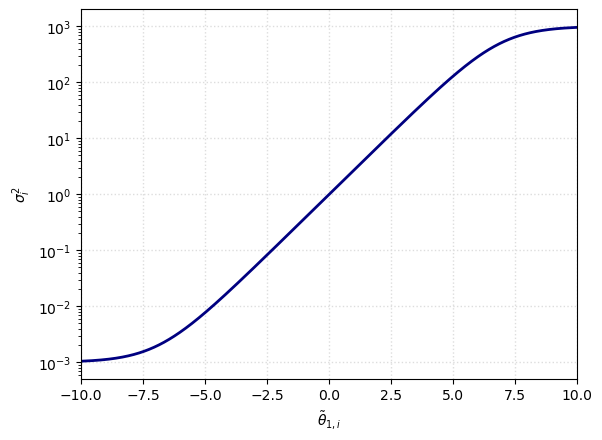

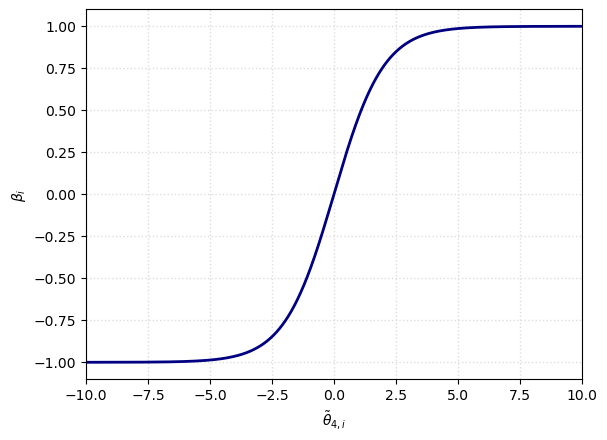

1.0
0.5


In [2]:
# Testing over X
XPlot = np.arange(-100,100,0.01)

# Define c_low and c_high
c_low = 0.001
c_high = 1000

# Compute values for every X
SigmaPlot = c_low+(c_high-c_low) / (1+np.exp(-XPlot)*((c_high-1) / (1-c_low)))
BPlot = 2 / (1+np.exp(-XPlot)) - 1

plt.plot(XPlot,SigmaPlot,c="navy",linewidth=2)
plt.xlabel(r"$\tilde{\theta}_{1,i}$")
plt.ylabel(r'$\sigma^2_i$')
plt.xlim(-10,10)
plt.yscale("log")
plt.grid(which='major', color='#DDDDDD', linestyle=':', linewidth=1.0)
plt.show()

plt.plot(XPlot,BPlot,c="navy",linewidth=2)
plt.xlabel(r"$\tilde{\theta}_{4,i}$")
plt.ylabel(r'$\beta_i$')
plt.xlim(-10,10)
plt.grid(which='major', color='#DDDDDD', linestyle=':', linewidth=1.0)
plt.show()

XTest = 0
print(c_low+(c_high-c_low) / (1+np.exp(-XTest)*((c_high-1) / (1-c_low))))
print(2 / (1+np.exp(-XTest)*1/3) - 1)

# Vector Data

In [326]:
# Parameters
N = 20
T = 1000
r = 2

### Simulate Data

In [327]:
start_time = time.time()

def sim_data(T,N,r):
    A = np.diag(np.array([0.9 - 0.1 * (k - 1) for k in range(1, r + 1)]))
    B = np.diag(np.array([0.9 - 0.1 * (k - 1) for k in range(1, r + 1)]))

    # Sim
    sigmas = np.random.uniform(0.1,1.1,N)
    Sigma = np.diag(sigmas)
    Lambda = np.random.normal(size=(N, r))

    Sigma_inv = inv(Sigma)
    Lambda_Sigma = Lambda.T @ Sigma_inv @ Lambda
    rotation_matrix = sqrtm(inv(Lambda_Sigma / N))

    Lambda_rotated = Lambda @ rotation_matrix

    # Verify the condition
    # condition_matrix = (Lambda_rotated.T @ Sigma_inv @ Lambda_rotated) / N
    # print(condition_matrix)

    factors = np.zeros((r,T))
    data = np.zeros((N,T))

    f_t = np.zeros((r,1))
    X_t = Lambda_rotated @ f_t + np.random.normal(np.zeros((N,1)),sigmas.reshape(-1,1),(N,1))

    for t in range(T):
        f_t = A @ inv(1/N * (Lambda_rotated.T @ Sigma_inv @ Lambda_rotated)) @ (1/N * Lambda_rotated.T @ Sigma_inv @ (X_t - Lambda_rotated @ f_t)) + B @ f_t
        X_t = Lambda_rotated @ f_t + np.random.normal(np.zeros((N,1)),sigmas.reshape(-1,1),(N,1))

        factors[:,t] = f_t.T
        data[:,t] = X_t.T

sim_data(T,N,r)
end_time = time.time()
print("runtime:",end_time-start_time)

runtime: 0.04699110984802246


### Find optimized parameters

In [48]:
# Define Manifold
manifold = Product([Euclidean(N), Stiefel(n=N, p=r),Euclidean(r), Euclidean(r)])

# Define the objective function
@pymanopt.function.autograd(manifold)
def llfun(theta_1,theta_2,theta_3,theta_4):
    
    # Transform variables
    Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_1)*((c_high-1) / (1-c_low))))
    Lamb_hat = anp.sqrt(N) * anp.sqrt(Sigma_hat) @ theta_2.reshape(N,r)
    A_hat = anp.diag(2 / (1+anp.exp(-theta_3)*1/3) - 1)
    B_hat = anp.diag(2 / (1+anp.exp(-theta_4)*1/3) - 1)

    llvalue = 0
    f_t = anp.zeros((r,1))
    factorz = np.zeros((r,T))
    
    for t in range(1,T):
    
        f_t = (A_hat @ anp.linalg.inv(1/N * (anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat) @ Lamb_hat)) @ (1/N * anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat) @ (anp.reshape(data[:,t-1],(-1,1)) - Lamb_hat @ f_t)) + B_hat @ f_t)

        x_hat = (anp.transpose(anp.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t) @ anp.linalg.inv(Sigma_hat) @ (anp.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t))[0][0]
        
        llvalue += 1/(T-1) * (-1/2 * anp.log(anp.linalg.det(Sigma_hat)) - N/2 * anp.log((2*anp.pi))+(-0.5*x_hat))
        
    return -llvalue

problem = Problem(manifold, llfun)
optimizer = pymanopt.optimizers.SteepestDescent(max_iterations=10)

init = [np.zeros(N),np.vstack((np.eye(r),np.zeros((N-r,r)))),np.zeros(r),np.zeros(r)]
Xopt = optimizer.run(problem, initial_point=init).point

print(Xopt)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    


C:\Users\joche\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
C:\Users\joche\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)


 1           +5.2612180685388354e+00    8.46008727e-01    
 2           +4.8063920813747343e+00    6.37035165e-01    
 3           +4.7855447500238384e+00    1.42798554e+00    
 4           +4.7042942944153801e+00    1.35630817e+00    
 5           +4.4317086080556738e+00    9.38446355e-01    
 6           +4.2765817930256151e+00    7.27601793e-01    
 7           +4.1829361411306749e+00    6.56508311e-01    
 8           +4.0920948356079281e+00    4.48495517e-01    
 9           +4.0287831035030015e+00    7.34581902e-01    
10           +3.9637447271968229e+00    6.40358063e-01    
Terminated - max iterations reached after 25.69 seconds.

[array([ 0.2373, -0.5357, -0.7238, -1.9268]), array([[ 0.5667,  0.1527],
       [ 0.1992,  0.816 ],
       [-0.2297, -0.3534],
       [-0.7658,  0.4313]]), array([-0.2434,  0.7679]), array([-0.014 ,  0.8365])]


## Optimized Algorithm

In [328]:
def sim_data(T,N,r):
    A = np.diag(np.array([0.9 - 0.1 * k for k in range(r)]))
    B = np.diag(np.array([0.9 - 0.1 * k for k in range(r)]))

    sigmas = np.random.uniform(0.1,1.1,N)
    Sigma = np.diag(sigmas)
    Lambda_pre = np.random.normal(size=(N, r))

    Sigma_inv = inv(Sigma)
    rotation_matrix = sqrtm(inv(Lambda_pre.T @ Sigma_inv @ Lambda_pre / N))

    Lambda = Lambda_pre @ rotation_matrix

    # Verify the condition
    # condition_matrix = (Lambda_rotated.T @ Sigma_inv @ Lambda_rotated) / N
    # print(condition_matrix)

    factors = np.zeros((r,T))
    data = np.zeros((N,T))

    f_t = np.zeros((r,1))
    X_t = Lambda @ f_t + np.random.normal(np.zeros(N),sigmas,(1,N)).reshape(-1,1)
    epsilon_t = np.random.normal(np.zeros(N),sigmas,(T,N))
    Lamb_Sig = 1/N * Lambda.T @ Sigma_inv
    
    for t in range(T):
        f_t = A @ (Lamb_Sig @ (X_t - Lambda @ f_t)) + B @ f_t
        X_t = Lambda @ f_t + epsilon_t[t].reshape(-1,1)
        
        factors[:,t] = f_t.T
        data[:,t] = X_t.T
        
    return factors, data

factors, data = sim_data(T,N,r)

runtime: 0.02301168441772461


In [329]:
# Define Manifold
manifold = Product([Euclidean(N), Stiefel(n=N, p=r),Euclidean(r), Euclidean(r)])

# Define the objective function
@pymanopt.function.autograd(manifold)
def llfun(theta_1,theta_2,theta_3,theta_4):
    
    # Transform variables
    Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_1)*((c_high-1) / (1-c_low))))
    Lamb_hat = anp.sqrt(N) * anp.sqrt(Sigma_hat) @ theta_2.reshape(N,r)
    A_hat = anp.diag(2 / (1+anp.exp(-theta_3)*1/3) - 1)
    B_hat = anp.diag(2 / (1+anp.exp(-theta_4)*1/3) - 1)
    
    llvalue = 0
    f_t = anp.zeros((r,1))
    Lamb_Sig = 1/N * anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat)
    Sigma_inv = anp.linalg.inv(Sigma_hat)
    X_breve = anp.reshape(data[:,0],(-1,1)) - Lamb_hat @ f_t
    
    for t in range(1,T):
        f_t = A_hat @ (Lamb_Sig @ X_breve) + B_hat @ f_t

        X_breve = anp.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t
        
        llvalue -= 0.5*(anp.transpose(X_breve) @ Sigma_inv @ (X_breve))[0][0]
    
    return -(llvalue / (T-1) - 1/2 * anp.log(anp.linalg.det(Sigma_hat)) - N/2 * anp.log(2*anp.pi))

def 
problem = Problem(manifold, llfun)
optimizer = pymanopt.optimizers.SteepestDescent(max_iterations=10)

init = [np.zeros(N),np.vstack((np.eye(r),np.zeros((N-r,r)))),np.zeros(r),np.zeros(r)]
Xopt = optimizer.run(problem, initial_point=init).point

print(Xopt)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +2.3288323813636563e+01    1.48269206e+00    
 2           +2.1850990831332993e+01    1.40428389e+00    
 3           +1.7127427015316229e+01    1.06914000e+00    
 4           +1.5198990875883496e+01    1.91978305e+00    
 5           +1.4873013909994604e+01    1.72566311e+00    
 6           +1.4331729821352438e+01    5.25213920e-01    
 7           +1.4271982931794627e+01    4.53088361e-01    
 8           +1.4234868362391710e+01    5.17046886e-01    
 9           +1.4217058280890047e+01    6.18248456e-01    
10           +1.4170579094862987e+01    2.43298734e-01    
Terminated - max iterations reached after 6.23 seconds.

[array([-0.4171,  0.1777, -1.5892, -1.6825, -2.144 , -1.2158, -2.3833,
       -0.1016, -0.3811, -2.68  , -1.7424, -4.2442, -0.4639, -0.4676,
       -2.1577, -0.2833, -2.9501, -2.7693, -0.3491, -0.3483]), array([[ 0.1805, 

# Tensor Data

In [604]:
# Parameters
T = 1000
d_array = np.array([10,5])
r_array = np.array([3,2])
d = np.prod(d_array)
r = np.prod(r_array)
K = len(d_array)

In [640]:
np.random.seed(1)

def sim_data():    
    A = np.diag(np.array([0.9 - 0.1 * k for j in range(r_array[0]) for k in range(r_array[1])]))
    B = np.diag(np.array([0.9 - 0.1 * k for j in range(r_array[0]) for k in range(r_array[1])]))

    sigmas = np.random.uniform(1,10,d)
    Sigma = np.diag(sigmas)
    Sigma_inv = inv(Sigma)
    
    U_k = []
    
    for k in range(K):
        U_pre = np.random.normal(size=(d_array[k], r_array[k]))

        # Rotate matrix
        U_k.append(U_pre @ sqrtm(inv(U_pre.T @ U_pre)))

        # Verify the condition
#         condition_matrix = (U_k[k].T @ U_k[k])
#         print(condition_matrix)
    
    factors_true = np.zeros(np.append(T,r_array))
    data = np.zeros(np.append(T,d_array))

    f_t = np.zeros((r,1))
    
    U_term = 1
    for k in range(K):
        U_term = np.kron(U_term,U_k[K-k-1])
    
    U_term = d**0.5 * sqrtm(Sigma) @ U_term
    
    X_t = U_term @ f_t + np.random.normal(np.zeros(d),sigmas,(1,d)).reshape(-1,1)
    
    epsilon_t = np.random.normal(np.zeros(d),sigmas,(T,d))
        
    U_Sig = 1/d * U_term.T @ Sigma_inv
    
    for t in range(T):
        f_t = A @ (U_Sig @ (X_t - U_term @ f_t)) + B @ f_t
        X_t = U_term @ f_t + epsilon_t[t].reshape(-1,1)
        
        factors_true[t] = f_t.reshape(r_array)
        data[t] = X_t.reshape(d_array)
        
    return factors_true, data

factors_true, data = sim_data()

In [638]:
# Define Manifold
manifold = Product([Euclidean(d), Stiefel(n=d_array[0], p=r_array[0]), Stiefel(n=d_array[1], p=r_array[1]), Euclidean(r), Euclidean(r)])

# Define the objective function
@pymanopt.function.autograd(manifold)
def llfun(theta_1,theta_2_1,theta_2_2,theta_3,theta_4):

    # Transform variables
    Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_1)*((c_high-1) / (1-c_low))))
    U_hat = d**0.5 * Sigma_hat**0.5 @ anp.kron(theta_2_2,theta_2_1)
    A_hat = anp.diag(2 / (1+anp.exp(-theta_3)*1/3) - 1)
    B_hat = anp.diag(2 / (1+anp.exp(-theta_4)*1/3) - 1)
    
    llvalue = 0
    f_t = anp.zeros((r,1))
    
    Sigma_inv = anp.linalg.inv(Sigma_hat)
    U_Sig = 1/d * anp.transpose(U_hat) @ Sigma_inv 
    X_breve = anp.reshape(data[0],(-1,1)) - U_hat @ f_t
        
    for t in range(1,T):
        
        f_t = A_hat @ (U_Sig @ X_breve) + B_hat @ f_t

        X_breve = anp.reshape(data[t],(-1,1)) - U_hat @ f_t
        
        llvalue -= 0.5*(anp.transpose(X_breve) @ Sigma_inv @ (X_breve))[0][0]
        
    final = -(llvalue / (T-1) - 1/2 * anp.log(anp.linalg.det(Sigma_hat)) - d/2 * anp.log(2*anp.pi))

    return final

problem = Problem(manifold, llfun)
optimizer = pymanopt.optimizers.SteepestDescent(max_iterations=30)

init = [np.zeros(d),np.vstack((np.eye(r_array[0]),np.zeros((d_array[0]-r_array[0],r_array[0])))), np.vstack((np.eye(r_array[1]),np.zeros((d_array[1]-r_array[1],r_array[1])))),np.zeros(r),np.zeros(r)]
Xopt = optimizer.run(problem, initial_point=init).point

print(Xopt)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +1.2426801641987786e+03    2.23341710e+02    
 2           +1.0426924706084699e+03    1.78895385e+02    
 3           +5.2468969106659313e+02    7.52657076e+01    
 4           +1.6100546277040618e+02    3.42235781e+00    


C:\Users\joche\AppData\Local\Temp\ipykernel_5424\2860208462.py:27: RuntimeWarning: overflow encountered in matmul
  llvalue -= 0.5*(anp.transpose(X_breve) @ Sigma_inv @ (X_breve))[0][0]


 5           +1.5853577787045487e+02    2.99165569e+00    
 6           +1.5353344578402329e+02    3.00510108e+00    
 7           +1.5328953930442108e+02    4.12906890e+00    
 8           +1.5225576487717538e+02    4.63834807e+00    
 9           +1.4863797908754896e+02    3.48476578e+00    
10           +1.4763548934362942e+02    2.72833689e+00    
11           +1.4729903717661364e+02    2.57049049e+00    
12           +1.4687610492973289e+02    1.68031177e+00    
13           +1.4677885792106937e+02    2.24747427e+00    
14           +1.4649944624998980e+02    1.09935417e+00    
15           +1.4646467738731772e+02    2.37488122e+00    
16           +1.4633927856877580e+02    1.91353816e+00    
17           +1.4611202591135327e+02    8.30461718e-01    
18           +1.4601008490922601e+02    1.21129427e+00    
19           +1.4591139920471616e+02    7.09312176e-01    
20           +1.4584469731044965e+02    1.29858100e+00    
21           +1.4576333801216632e+02    9.10559575e-01  

In [ ]:
def calRMSE(theta_hat):
    
    # Transform variables
    Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_1)*((c_high-1) / (1-c_low))))
    U_hat = d**0.5 * Sigma_hat**0.5 @ anp.kron(theta_2_2,theta_2_1)
    A_hat = anp.diag(2 / (1+anp.exp(-theta_3)*1/3) - 1)
    B_hat = anp.diag(2 / (1+anp.exp(-theta_4)*1/3) - 1)
    
    f_t = anp.zeros((r,1))
    factorz = np.zeros(np.append(T,r_array))
    
    U_Sig = 1/d * anp.transpose(U_hat) @ Sigma_inv 
    X_breve = anp.reshape(data[0],(-1,1)) - U_hat @ f_t
        
    for t in range(1,T):
        
        f_t = A_hat @ (U_Sig @ X_breve) + B_hat @ f_t - Lamb_hat @ f_t)) + B_hat @ f_t)
                    
        factors[t] = f_t.reshape(r_array)
        
    for i in range(r):
        print("For r=",i,":")
        factor_true = factors[np.argsort(np.var(factors,(1)))[i]]
        factor_opt = factorz[np.argsort(np.var(factorz,(1)))[i]]
        print(np.argsort(np.var(factors,(1)))[i])
        
        if (0 > np.corrcoef(factor_true,factor_opt)[0,1]):
            factor_opt = -factor_opt
        print("RMSE=",sum((factor_opt-factor_true)**2)/T)
        sns.lineplot(factor_true)
        sns.lineplot(factor_opt)
        plt.show()
        print("---")
        
calRMSE(Xopt)

In [49]:
def llfun_0(bool1,bool2,bool3,bool4):

    Sigma_hat = Sigma
    Lamb_hat = Lambda_rotated
    A_hat = A
    B_hat = B
    
    if bool1 == "Opt_val":
        Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-Xopt[0])*((c_high-1) / (1-c_low))))
    if bool2 == "Opt_val":
        Lamb_hat = anp.sqrt(N) * anp.sqrt(Sigma_hat) @ Xopt[1].reshape(N,r)
    if bool3 == "Opt_val":
        A_hat = anp.diag(Xopt[2])
    if bool4 == "Opt_val":
        B_hat = anp.diag(2 / (1+anp.exp(-Xopt[3])*1/3) - 1)
        
    
    llvalue = 0
        
#     print()
#     print(Sigma_hat)
#     print(Lamb_hat)
#     print(A_hat)
#     print(B_hat)

    f_t = anp.zeros((r,1))
    factorz = np.zeros((r,T))
    gFun = 0
    for t in range(1,T):
        
#         f_t = (A_hat @ anp.linalg.inv(1/N * (anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat) @ Lamb_hat)) @ (1/N * anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat) @ (anp.reshape(data[:,t-1],(-1,1)) - Lamb_hat @ f_t)) + B_hat @ f_t)
        
#         x_hat = (anp.transpose(anp.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t) @ anp.linalg.inv(Sigma_hat) @ (anp.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t))[0][0]
        
#         gFun = (anp.log((2*anp.pi)**(-N/2))+(-0.5*x_hat))
        
#         llvalue += 1/T * (-1/2 * anp.log(anp.linalg.det(Sigma_hat))+gFun)
        
        f_t = (A_hat @ anp.linalg.inv(1/N * (anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat) @ Lamb_hat)) @ (1/N * anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat) @ (anp.reshape(data[:,t-1],(-1,1)) - Lamb_hat @ f_t)) + B_hat @ f_t)
        
#         x_hat = (anp.transpose(anp.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t) @ anp.linalg.inv(Sigma_hat) @ (anp.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t))[0][0]
        
#         gFun = (anp.log((2*anp.pi)**(-N/2))+(-0.5*x_hat))
        
#         llvalue += 1/T * (-1/2 * anp.log(anp.linalg.det(Sigma_hat))+gFun)
        
        pVal = -N/2*np.log(2*np.pi) - 1/2*np.log(np.linalg.det(Sigma_hat)) - 1/2*np.transpose(np.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t)@np.linalg.inv(Sigma_hat)@(np.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t)
        gFun += 1/T*(- 1/2*np.transpose(np.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t)@np.linalg.inv(Sigma_hat)@(np.reshape(data[:,t],(-1,1)) - Lamb_hat @ f_t))
        llvalue += 1/T * pVal
        
    print("Pi part")
    print(-N/2*np.log(2*np.pi))
    print("Determinant part")
    print(-1/2*np.log(np.linalg.det(Sigma_hat)))
    print("The rest of the function")
    print(gFun)
    print("Total log likelihood function")
    print(llvalue)
    print()

Bool_array = np.array(["True_val", "Opt_val"])

# for bool1 in Bool_array:
#     for bool2 in Bool_array:
#         for bool3 in Bool_array:
#             for bool4 in Bool_array:
#                 print("Sigma",bool1,"  Lamb",bool2,"  A",bool3,"  B",bool4)
#                 llfun_0(bool1,bool2,bool3,bool4)
llfun_0("True_val","True_val","True_val","True_val")
llfun_0("Opt_val","Opt_val","Opt_val","Opt_val")

Pi part
-3.6757541328186907
Determinant part
1.1024893424601765
The rest of the function
[[-1.4097]]
Total log likelihood function
[[-3.9744]]

Pi part
-3.6757541328186907
Determinant part
1.4700593929348433
The rest of the function
[[-2.4677]]
Total log likelihood function
[[-4.6661]]



In [470]:
I_1 = 30
I_2 = 40
I_3 = 50
J = 20

X = np.random.uniform(0,1,(I_1,I_2,I_3))
Y = np.random.uniform(0,1,(J,I_1))
Z = tensorly.tenalg.mode_dot(X,Y,0)
print("ZZZ")
# print(tensorly.tenalg.mode_dot(X,Y,1))
# print(tensorly.tenalg.mode_dot(X,Y,0))
# print(Z.shape)

i1 = 12
i2 = 11
i3 = 15
j = 10

print(Z[j,i2,i3])
# print(Z)
test0 = 0

for i_n in range(I_1):
    test0 += X[i_n,i2,i3] * Y[j,i_n]
    
print(test0)

ZZZ
10.456579506545504
10.4565795065455


In [17]:
print(Sigma)
print(Lambda_rotated)
print(A)
print(B)
print(anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-Xopt[0])*((c_high-1) / (1-c_low)))))
print(anp.sqrt(N) * anp.sqrt(anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-Xopt[0])*((c_high-1) / (1-c_low))))) @ Xopt[1].reshape(N,r))
print(anp.diag(Xopt[2]))
print(anp.diag(2 / (1+anp.exp(-Xopt[3])*1/3) - 1))

[[1.0664 0.     0.     0.    ]
 [0.     0.5883 0.     0.    ]
 [0.     0.     0.6631 0.    ]
 [0.     0.     0.     0.265 ]]
[[ 0.287  -0.6756]
 [ 1.2723 -0.477 ]
 [-0.5469  0.3199]
 [ 0.4369  0.8962]]
[[0.9 0. ]
 [0.  0.8]]
[[0.9 0. ]
 [0.  0.8]]
[[1.1924 0.     0.     0.    ]
 [0.     0.602  0.     0.    ]
 [0.     0.     0.4221 0.    ]
 [0.     0.     0.     0.1264]]
[[ 0.1136 -0.828 ]
 [ 1.1908 -0.4957]
 [-0.5387  0.4055]
 [ 0.3459  0.5763]]
[[0. 0.]
 [0. 0.]]
[[0.5 0. ]
 [0.  0.5]]


For r= 0 :
1
RMSE= 0.01409205326766025


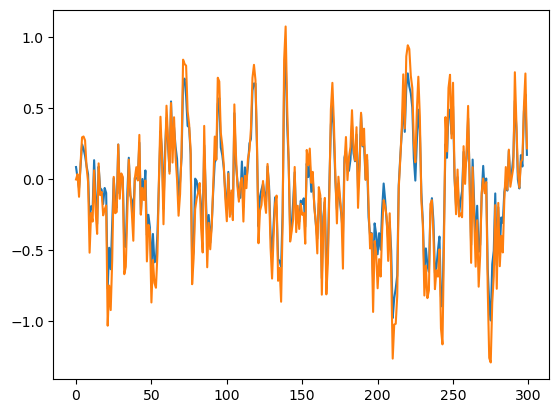

---
For r= 1 :
0
RMSE= 0.020961880871387013


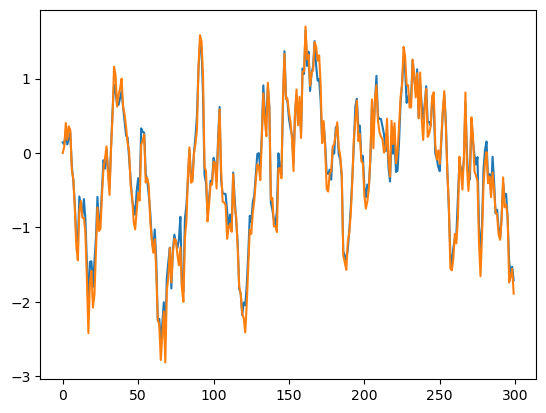

---


In [16]:
def calRMSE(theta_hat):
    
    Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_hat[0])*((c_high-1) / (1-c_low))))
    Lamb_hat = anp.sqrt(N) * anp.sqrt(Sigma_hat) @ theta_hat[1].reshape(N,r)
    A_hat = anp.diag(theta_hat[2])
    B_hat = anp.diag(2 / (1+anp.exp(-theta_hat[3])*1/3) - 1)
    
    f_t = anp.zeros((r,1))
    factorz = np.zeros((r,T))

    for t in range(1,T):
    
        f_t = (A_hat @ anp.linalg.inv(1/N * (anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat) @ Lamb_hat)) @ (1/N * anp.transpose(Lamb_hat) @ anp.linalg.inv(Sigma_hat) @ (anp.reshape(data[:,t-1],(-1,1)) - Lamb_hat @ f_t)) + B_hat @ f_t)
                    
        factorz[:,t] = f_t.T
        
    for i in range(r):
        print("For r=",i,":")
        factor_true = factors[np.argsort(np.var(factors,(1)))[i]]
        factor_opt = factorz[np.argsort(np.var(factorz,(1)))[i]]
        print(np.argsort(np.var(factors,(1)))[i])
        
        if (0 > np.corrcoef(factor_true,factor_opt)[0,1]):
            factor_opt = -factor_opt
        print("RMSE=",sum((factor_opt-factor_true)**2)/T)
        sns.lineplot(factor_true)
        sns.lineplot(factor_opt)
        plt.show()
        print("---")
        
calRMSE(Xopt)


In [65]:
gg = 5
tt = 2000

mu = np.ones(gg)
V = np.random.uniform(0.1,1.1,gg)
df = np.random.normal(mu,V,(tt,gg))

print(df[0])

[0.8334 0.5335 1.7972 2.1115 1.1735]


In [66]:

# Define Manifold
manifold = Product([Euclidean(gg), Euclidean(gg)])

# Define the objective function
@pymanopt.function.autograd(manifold)
def llfun_new(theta_1,theta_2):
    
    mu_hat = theta_1.reshape(-1,1)
    V_hat = anp.diag(anp.abs(theta_2))

    llvalue = 0
    
    for tim in range(1,tt):
    
        x_hat = (anp.transpose(anp.reshape(df[tim],(-1,1)) - mu_hat) @ anp.linalg.inv(V_hat) @ (anp.reshape(df[tim],(-1,1)) - mu_hat))[0][0]
        llvalue += 1/tt * (-1/2 * anp.log(anp.linalg.det(V_hat)) - gg/2 * anp.log((2*anp.pi))+(-0.5*x_hat))
        
    return -llvalue

problem = Problem(manifold, llfun_new)
optimizer = pymanopt.optimizers.SteepestDescent(max_iterations=20)

# init = [,np.zeros(r),np.zeros(r)]
Xopt = optimizer.run(problem).point

print(Xopt)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +2.7104740654917592e+01    3.69689676e+01    
 2           +1.4491418462280443e+01    6.58063106e+00    
 3           +8.3908208951632144e+00    1.34223437e+00    
 4           +7.6432377008563526e+00    5.74656404e-01    
 5           +7.4716620231721835e+00    1.39412810e+00    
 6           +6.9567330322726280e+00    8.49596930e-01    
 7           +6.6409719484573460e+00    2.69412060e+00    
 8           +5.7963307410302196e+00    1.14907220e+00    
 9           +5.7658972042800940e+00    1.81988366e+00    
10           +5.6456393185899714e+00    1.81447945e+00    
11           +5.2978322964428557e+00    8.43284000e+00    
12           +5.2382871340760335e+00    1.60524257e+00    
13           +5.1811338580160395e+00    1.45055475e+00    
14           +5.1763554301034871e+00    1.22821975e+00    
15           +5.1652968052744566e+00    8.

In [67]:
print(mu)
print(V)
print(Xopt[0])
print(Xopt[1])

[1. 1. 1. 1. 1.]
[0.2457 0.4416 0.96   0.9452 0.3907]
[0.9915 1.2157 1.0332 1.0104 1.0043]
[-0.0391 -0.8153 -1.022   4.5548 -0.8416]


In [68]:
def llfun_newtest():
    print("True")
    mu_hat = np.ones(gg).reshape(-1,1)
    V_hat = anp.diag(np.ones(gg))

    llvalue = 0
    x_hat_sum = 0
    for tim in range(1,tt):
    
        x_hat = (anp.transpose(anp.reshape(df[tim],(-1,1)) - mu_hat) @ anp.linalg.inv(V_hat) @ (anp.reshape(df[tim],(-1,1)) - mu_hat))[0][0]
        llvalue += 1/tt * (-1/2 * anp.log(anp.linalg.det(V_hat)) - gg/2 * anp.log((2*anp.pi))+(-0.5*x_hat))
        x_hat_sum += 1/tt * (-0.5*x_hat)
    
    print("Pi part")
    print(-gg/2*np.log(2*np.pi))
    print("Determinant part")
    print(-1/2 * anp.log(anp.linalg.det(V_hat)))
    print("The rest of the function")
    print(x_hat_sum)
    print("Total log likelihood function")
    print(llvalue)
    print()    
    print("Opt")
    
    mu_hat = Xopt[0].reshape(-1,1)
    V_hat = anp.diag(anp.abs(Xopt[1]))

    llvalue = 0
    x_hat_sum = 0
    for tim in range(1,tt):
    
        x_hat = (anp.transpose(anp.reshape(df[tim],(-1,1)) - mu_hat) @ anp.linalg.inv(V_hat) @ (anp.reshape(df[tim],(-1,1)) - mu_hat))[0][0]
        llvalue += 1/tt * (-1/2 * anp.log(anp.linalg.det(V_hat)) - gg/2 * anp.log((2*anp.pi))+(-0.5*x_hat))
        x_hat_sum += 1/tt * (-0.5*x_hat)
    
    print("Pi part")
    print(-gg/2*np.log(2*np.pi))
    print("Determinant part")
    print(-1/2 * anp.log(anp.linalg.det(V_hat)))
    print("The rest of the function")
    print(x_hat_sum)
    print("Total log likelihood function")
    print(llvalue)
    print()
    
llfun_newtest()



True
Pi part
-4.594692666023363
Determinant part
-0.0
The rest of the function
-1.100179600427554
Total log likelihood function
-5.692574920117906

Opt
Pi part
-4.594692666023363
Determinant part
1.0405853918147947
The rest of the function
-1.5548233026051577
Total log likelihood function
-5.1071535231766205



Pi part
-3.6757541328186907
Determinant part
1.1024893424601765
The rest of the function
[[-1.4097]]
Total log likelihood function
[[-3.9744]]

Pi part
-3.6757541328186907
Determinant part
1.4700593929348433
The rest of the function
[[-2.4677]]
Total log likelihood function
[[-4.6661]]
